# Preparing the Dataset

In [22]:
import os 
import sys 
from collections import Counter
import re
from typing import List
import spacy 
import json 
import matplotlib.pyplot as plt 
import numpy as np
import pickle
import torch

In [2]:
nlp = spacy.load("en_core_web_sm")
nlp

In [3]:
def read_text_file(path: str) -> str:
    
    with open(path, "r", encoding='utf-8') as f: 
        text = f.read()
    return text

def generate_tokens_nlp(text: str, nlp=nlp):
    
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]
    return tokens

In [6]:
train_pos_path = "data/train/positive/"
train_neg_path = "data/train/negative/"

train_dict = {} # { 'hello there' : 0, "hi there" : 1 }
len_list = []
word_counter = Counter()

for example_path in os.listdir(train_pos_path): 
    
    doc_path = os.path.join(train_pos_path, example_path)
    text = read_text_file(doc_path)
    tokens = generate_tokens_nlp(text)
    
    if len(tokens) == 0: 
        print(example_path)
    
    word_counter.update(tokens)
    len_list.append(len(tokens))
    train_dict[' '.join(tokens)] = 1
    
for example_path in os.listdir(train_neg_path):
    
    doc_path = os.path.join(train_neg_path, example_path)
    text = read_text_file(doc_path)
    tokens = generate_tokens_nlp(text)
    
    if len(tokens) == 0: 
        print(example_path)
        
    word_counter.update(tokens)
    len_list.append(len(tokens))
    train_dict[' '.join(tokens)] = 0
    
with open("data/train.json", "w") as f: 
    json.dump(train_dict, f, indent=10)

In [8]:
len(train_dict), len(word_counter)

(1985, 21701)

In [115]:
with open("data/word_counter.pkl", "wb") as f: 
    pickle.dump(word_counter, f)

In [116]:
with open("data/len_list.pkl", "wb") as f: 
    pickle.dump(len_list, f)

In [9]:
num_pos = 0
for key, value in train_dict.items():
    num_pos += value 
    
print(num_pos, len(train_dict)-num_pos)

999 986


In [10]:
print(len(len_list))
avg_len = sum(len_list) / len(len_list)
print(avg_len)

max_len = max(len_list)
print(max_len)

2000
73.662
1554


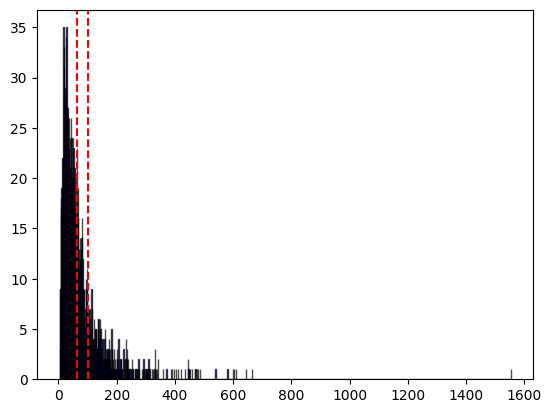

In [61]:
plt.hist(len_list, bins=2000, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(x=100, color="red", linestyle="--")
plt.axvline(x=64, color="red", linestyle="--")

In [9]:
# let's check where the examples are going missing 
# some of the reviews are miss classified

my_set = set()

for example_path in os.listdir(train_pos_path):
    
    doc_path = os.path.join(train_pos_path, example_path)
    with open(doc_path, "r") as f: 
        text = f.read()
        
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]
    s = " ".join(tokens)
    
    if s in my_set: 
        print(doc_path)
    my_set.add(s)
    
for example_path in os.listdir(train_neg_path):
    
    doc_path = os.path.join(train_neg_path, example_path)
    with open(doc_path, "r") as f: 
        text = f.read()
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha] 
    s = " ".join(tokens)
    if s in my_set: 
        print(doc_path)
    my_set.add(s)

data/train/positive/1611
data/train/negative/658
data/train/negative/851
data/train/negative/723
data/train/negative/961
data/train/negative/761
data/train/negative/410
data/train/negative/615
data/train/negative/473
data/train/negative/495
data/train/negative/124
data/train/negative/1210
data/train/negative/1889
data/train/negative/1084
data/train/negative/178


- Let's get the pre-trained emebddings

In [11]:
with open("data/all.review.vec.txt", "r", encoding="utf-8") as file: 
    lines = file.readlines()
    
print(type(lines))
print(len(lines))

print(lines[0]) # num_words, embedding_dim
lines = lines[1:]

<class 'list'>
56051
56050 100



In [12]:
embedding = {"</p>" : ([float(0)]*100)} # padding token

for line in lines: 
    parts = line.strip().split()
    word = parts[0]
    vec = [float(val) for val in parts[1:]]
    embedding[word] = vec
    
print(len(embedding))


with open("data/embedding.json", "w") as f: 
    json.dump(embedding, f, indent=4)

56051


In [13]:
with open("data/embedding_words.txt", "w") as f: 
    
    for key in embedding.keys():
        print(key, file=f)

In [14]:
MAX_LEN = 80
PADDING_TOKEN = "</p>"
SOS_TOKEN = "</s>"

In [15]:
def text_2_vec(text: str, embedding=embedding, max_len=MAX_LEN, sos_token=SOS_TOKEN, pad_token=PADDING_TOKEN) -> List[List[float]]:
    
    # returns a 2 dim list embeddings of the following sentence
    words = [sos_token] + text.lower().split()
    
    if len(words) < max_len:
        words = words + (max_len - len(words)) * [pad_token]
    
    elif len(words) > MAX_LEN:
        words = words[:max_len]
                
    input_sent = []
    for word in words:
        if word not in embedding.keys():
            # add a padding token at the end of the sentence at skip this word
            words.append(pad_token)
            
        else: 
            input_sent.append(embedding[word])
    
    return input_sent

In [121]:
# preparing the dataset using the pre-trained embeddings first
# skipping the out of vocab words

input_data = [] # list of lists : later convert into numpy array
input_labels = []

with open("data/train.json", "r") as f: 
    train_dict = json.load(f)

for key, value in train_dict.items():
    
    input_labels.append(int(value))    
    input_sent = text_2_vec(key)    
    input_data.append(input_sent)

np_input_data = np.array(input_data, dtype=np.float32)
np_input_labels = np.array(input_labels)

print(f"np_input_data.shape = {np_input_data.shape}, np_input_labels.shape = {np_input_labels.shape}")

np_input_data.shape = (1985, 80, 100), np_input_labels.shape = (1985,)


In [122]:
with open("data/data_pretrained_embeddings/np_train_input_80.pkl", "wb") as f: 
    pickle.dump(np_input_data, f) 

with open("data/data_pretrained_embeddings/np_train_labels.pkl", "wb") as f: 
    pickle.dump(np_input_labels, f)

In [127]:
# let's prepare the same for the test set as well
test_labels_path_pos = "data/test/positive"
test_labels_path_neg = "data/test/negative"
test_data_input = []
test_data_labels = []

for example_path in os.listdir(test_labels_path_pos):
    
    doc_path = os.path.join(test_labels_path_pos, example_path)
    text = read_text_file(doc_path)
    tokens = generate_tokens_nlp(text)
    test_sent = text_2_vec(' '.join(tokens))
    test_data_input.append(test_sent)
    test_data_labels.append(int(1))
    
for example_path in os.listdir(test_labels_path_neg):
    
    doc_path = os.path.join(test_labels_path_neg, example_path)
    text = read_text_file(doc_path)
    tokens = generate_tokens_nlp(text)
    test_sent = text_2_vec(' '.join(tokens))
    test_data_input.append(test_sent)
    test_data_labels.append(int(0))    
    
np_test_input = np.array(test_data_input, dtype=np.float32)
np_test_labels = np.array(test_data_labels, dtype=np.int64)

print(f"np_test_input.shape = {np_test_input.shape}, np_test_labels.shape = {np_test_labels.shape}")
print(f"np_test_input.dtype = {np_test_input.dtype}, np_test_labels.dtype = {np_test_labels.dtype}")

np_test_input.shape = (2000, 80, 100), np_test_labels.shape = (2000,)
np_test_input.dtype = float32, np_test_labels.dtype = int64


In [130]:
with open("data/data_pretrained_embeddings/np_test_input_80.pkl", "wb") as f: 
    pickle.dump(np_test_input, f)
    
with open("data/data_pretrained_embeddings/np_test_labels.pkl", "wb") as f: 
    pickle.dump(np_test_labels, f)

- let's prepare dataset for non-pretrained embeddings as well

In [16]:
num_words = len(word_counter)
print(f"num_words = {num_words}")

num_words = 21701


In [17]:
VOCAB_SIZE = int(1e4) 
print(VOCAB_SIZE)

10000


In [18]:
small_counter = word_counter.most_common(VOCAB_SIZE) # [(word, count)]
word2index = {SOS_TOKEN: 0, PADDING_TOKEN: 1}
index2word = {0: SOS_TOKEN, 1: PADDING_TOKEN}
num_words = 2

for word, count in small_counter:
    word2index[word] = num_words
    index2word[num_words] = word 
    num_words += 1
    
print(f"num_words = {num_words}")

num_words = 10002


In [134]:
with open("data/data_train_embeddings/word2index.pkl", "wb") as f: 
    pickle.dump(word2index, f)

with open("data/data_train_embeddings/index2word.pkl", "wb") as f: 
    pickle.dump(index2word, f)

In [19]:
def text2index(text: str, word2index=word2index, max_len=MAX_LEN, sos_token=SOS_TOKEN, pad_token=PADDING_TOKEN) -> List[int]:
    
    # skipping out of vocab words and adding a padding token for it at the end
    
    words = [sos_token] + text.lower().split()
    
    if len(words) < max_len:
        words = words + (max_len - len(words)) * [pad_token]
    
    elif len(words) > MAX_LEN:
        words = words[:max_len]
                
    input_sent = []
    for word in words: 
        if word not in word2index.keys():
            words.append(pad_token)
        else: 
            input_sent.append(int(word2index[word]))
    
    return input_sent

In [20]:
input_data = []

with open("data/train.json", "r") as f: 
    train_dict = json.load(f)
    
for text in train_dict.keys():
    
    input_sent = text2index(text)
    input_data.append(input_sent)
    
np_input_data = np.array(input_data)
print(f"np_input_data.shape = {np_input_data.shape}, np_input_data.dtype = {np_input_data.dtype}")

np_input_data.shape = (1985, 80), np_input_data.dtype = int64


In [24]:
with open("data/data_train_embeddings/np_train_input_80.pkl", "wb") as f: 
    pickle.dump(np_input_data, f)

In [25]:
# let's prepare the same for the test set as well
test_labels_path_pos = "data/test/positive"
test_labels_path_neg = "data/test/negative"
test_data_input = []
test_data_labels = []

for example_path in os.listdir(test_labels_path_pos):
    
    doc_path = os.path.join(test_labels_path_pos, example_path)
    text = read_text_file(doc_path)
    tokens = generate_tokens_nlp(text)
    test_sent = text2index(' '.join(tokens))
    
    test_data_input.append(test_sent)
    test_data_labels.append(int(1))
    
    
for example_path in os.listdir(test_labels_path_neg):
    
    doc_path = os.path.join(test_labels_path_neg, example_path)
    text = read_text_file(doc_path)
    tokens = generate_tokens_nlp(text)
    test_sent = text2index(' '.join(tokens))
    
    test_data_input.append(test_sent)
    test_data_labels.append(int(0))    
    
np_test_input = np.array(test_data_input, dtype=np.int64)
np_test_labels = np.array(test_data_labels, dtype=np.int64)

print(f"np_test_input.shape = {np_test_input.shape}, np_test_labels.shape = {np_test_labels.shape}")
print(f"np_test_input.dtype = {np_test_input.dtype}, np_test_labels.dtype = {np_test_labels.dtype}")

np_test_input.shape = (2000, 80), np_test_labels.shape = (2000,)
np_test_input.dtype = int64, np_test_labels.dtype = int64


In [105]:
with open("data/data_train_embeddings/np_test_input_80.pkl", "wb") as f: 
    pickle.dump(np_test_input, f)
    
with open("data/data_train_embeddings/np_test_labels.pkl", "wb") as f: 
    pickle.dump(np_test_labels, f)